In [1]:
import numpy as np
import scipy.stats as stats
from modules import sample_size
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

# Hypotheses

**Null:** Control and treatment samples are part of the same binomial distribution. Treatment prob - Control prob <= 0.

**Alt:** Treatment sample is part of a binomial distribution with mean higher than that of control. Treatment prob - Control prob > 0.

# Step 1: Derive Stat Power from Probs and Sample Sizes

Alt Hypothesis: Treatment - Control > 0

Control Sample Size: 1,000
Treatment Sample Size: 1,000
Significance Threshold: 0.0500
Statisical Power: 0.7966


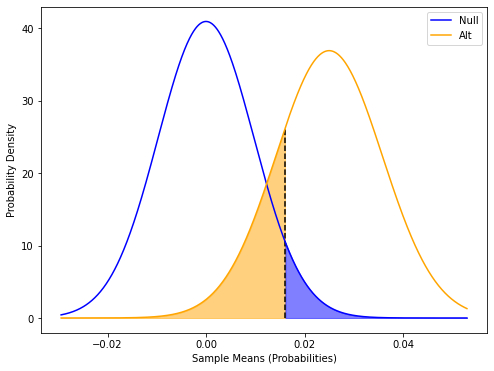

In [16]:
power, fig, ax = sample_size.find_power(p_control = 0.05, p_treatment = 0.075, report = True, plot = True)

# Step 2: Derive Sample Size from Stat Power and Probs

## Great Notes from Udacity Instructor with Additions from Me

Now that we've got some intuition for power by using trial and error, we can now approach a closed-form solution for computing a minimum experiment size. The key point to notice is that, for an $\alpha$ and $\beta$ both < .5, the critical value for determining statistical significance will fall between our null click-through rate and our alternative, desired click-through rate. So, the difference between $p_0$ and $p_1$ can be subdivided into the distance from $p_0$ to the critical value $p^*$ and the distance from $p^*$ to $p_1$.

Those subdivisions can be expressed in terms of the standard error and the z-scores:



$$p^* - p_0 = z_{1-\alpha} SE_{0},$$
$$p_1 - p^* = -z_{\beta} SE_{1};$$

$$p_1 - p_0 = z_{1-\alpha} SE_{0} - z_{\beta} SE_{1}$$

**Ryan Note:** These formulae skip a bunch of algebraic simplification. Z score calculation starts like this:

$$z_{observed} = \frac{(p_{observed} - p_{mean})}{SE_{mean}}$$

**End Ryan Note**

In turn, the standard errors can be expressed in terms of the standard deviations of the distributions, divided by the square root of the number of samples in each group:

$$SE_{0} = \frac{s_{0}}{\sqrt{n}},$$
$$SE_{1} = \frac{s_{1}}{\sqrt{n}}$$

Substituting these values in and solving for $n$ will give us a formula for computing a minimum sample size to detect a specified difference, at the desired level of power:

$$n = \lceil \big(\frac{z_{\alpha} s_{0} - z_{\beta} s_{1}}{p_1 - p_0}\big)^2 \rceil$$

where $\lceil ... \rceil$ represents the ceiling function, rounding up decimal values to the next-higher integer. Implement the necessary variables in the function below, and test them with the cells that follow.

In [18]:
n = sample_size.find_sample_size(p_control = 0.05, p_treatment = 0.075, power = 0.80, report = True)

Minimal Practical Difference Needed: 0.0250
Desired Statistical Power: 0.8
Recommended Responses per Sample Group: 1,011


# Step 3: Study Power and Effect Size, Effect on Sample Size

Null conversion rate is 10%.

How do our sample size needs change as our desired effect increases alt conversion rate to 11, 12, 13, 14 and 15%?

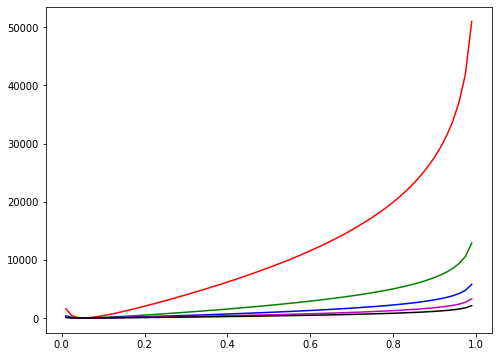

In [11]:
p_control = 0.2
test_powers = np.linspace(0.01,.99,66)
samples = []
colors = ['r','g','b','m','k']
for i in np.linspace(p_control + 0.01, p_control + 0.05, 5):
    samples.append([sample_size.find_sample_size(p_control = p_control, p_treatment = i, power = x, alpha = 0.05) for x in test_powers])
               
fig, ax = plt.subplots(1,1,figsize = (8,6))

for i, color in zip(samples, colors):
    ax.plot(test_powers, i, color = color)

plt.show();